# Поиск изображения по тексту описания

Задание: разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок необходимо выбрать либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from tqdm import tqdm, notebook
from tqdm.notebook import tqdm
tqdm.pandas()

from PIL import Image
import os

import transformers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor

RANDOM_STATE = 42
TRASHOLD = 0.7
EPOCHS=100

### Оценка краудсорсинга

Краудсо́рсинг (англицизм от crowdsourcing, от crowd — толпа и sourcing — использование или привлечение ресурсов) — привлечение к решению тех или иных проблем инновационной производственной деятельности широкого круга лиц для использования их творческих способностей, знаний и опыта по типу субподрядной работы на добровольных началах с применением информационных технологий.

Из данного определения следует, что оценку из данной таблицы стоит учитывать в меньшей степени, так как привлекаются непрофессионалы, которые не компетентны, да и не заинтересованы в правильности выдаваемых оценок.

Загружаем данные оценок краудсорсинга. В данном файлу отсутсвуют названия колонок, поэтому присвоим их с помощью аргумента names.

In [2]:
DATA_PATH = 'to_upload'

In [3]:
crowd_data = pd.read_csv(os.path.join(DATA_PATH, 'CrowdAnnotations.tsv'), sep='\t', header=None,
                         names=['image', 'query_id', 'crowd',
                                'assessment_true', 'assessment_false'])

Проверим инфмормацию о датасете.

In [4]:
crowd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   crowd             47830 non-null  float64
 3   assessment_true   47830 non-null  int64  
 4   assessment_false  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В датасете имеется около 48 тысяч записей, пропуски отсутствуют. Выведем случайные 5 строк.

In [5]:
crowd_data.sample(5)

image                     query_id  crowd  \
37458  3564312955_716e86c48b.jpg   820169182_f5e78d7d19.jpg#2    0.0   
32100  3365783912_e12c3510d8.jpg  3186073578_6e115f45f5.jpg#2    0.0   
46057   561417861_8e25d0c0e8.jpg  3562050678_4196a7fff3.jpg#2    0.0   
46508   732468337_a37075225e.jpg   339658315_fbb178c252.jpg#2    0.0   
3606   1561658940_a947f2446a.jpg  2354540393_a149722680.jpg#2    0.0   

       assessment_true  assessment_false  
37458                0                 3  
32100                0                 3  
46057                0                 3  
46508                0                 3  
3606                 0                 3

Из представленных данных видно, что в столбце **image** находятся названия файла изображения, в столбце **query_id** - идентификатор текстового запроса в формате названия изображения и '#2'. Стобец **crowd** хранит долю подтвердивших соответствие от общего числа респондентов.

В стобцах **assessment_true**	и **assessment_false** количество респондентов подтвердивших соответствие/не соответствие текста и картинки. По сути, данные столбцы дублируют информацию столбца **crowd** и для предсказания не несут никакого информационного смысла.

Для случайного изображения выведем все записи.

In [6]:
crowd_data[crowd_data['image']=='384577800_fc325af410.jpg']

image                     query_id  crowd  \
41740  384577800_fc325af410.jpg  1119015538_e8e796281e.jpg#2    0.0   
41741  384577800_fc325af410.jpg  1131932671_c8d17751b3.jpg#2    0.0   
41742  384577800_fc325af410.jpg  1389264266_8170bc1c54.jpg#2    0.0   
41743  384577800_fc325af410.jpg  1392272228_cf104086e6.jpg#2    0.0   
41744  384577800_fc325af410.jpg  1764955991_5e53a28c87.jpg#2    0.0   
...                         ...                          ...    ...   
41815  384577800_fc325af410.jpg   391579205_c8373b5411.jpg#2    0.0   
41816  384577800_fc325af410.jpg   422763475_0bc814dac6.jpg#2    0.0   
41817  384577800_fc325af410.jpg   430173345_86388d8822.jpg#2    0.0   
41818  384577800_fc325af410.jpg   505929313_7668f021ab.jpg#2    0.0   
41819  384577800_fc325af410.jpg   925491651_57df3a5b36.jpg#2    0.0   

       assessment_true  assessment_false  
41740                0                 3  
41741                0                 3  
41742                0                 3  
41743                0                 3  
41744                0                 3  
...                ...               ...  
41815                0                 3  
41816                0                 3  
41817                0                 3  
41818                0                 3  
41819                0                 3  

[80 rows x 5 columns]

Для случайного изображения имеется 80 записей в таблице, большая часть из которых соответсвует оценке 0.

Выведем все совпадения в столбце **crowd**.

In [7]:
crowd_data['crowd'].value_counts()

0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: crowd, dtype: int64

Как видно 42 из 48 тысяч записей имееют долю подтвердивших соответсвия равную 0. В 3 тысячах случаев только треть респондентов подтвердили совпадение.

Посмотрим количество уникальных значений в разных столбцах таблицы.

In [8]:
crowd_data.nunique()

image               1000
query_id            1000
crowd                 12
assessment_true        6
assessment_false       7
dtype: int64

Данная информация подсказывает, что количество уникальных изображений и текстов в датасете равняется 1 000.

Так как столбцы **assessment_true** и **assessment_false** дублируют информацию из столбца **crowd**, логично удалить их из датасета.

### Оценка экспертов

Оценка экспертов в бОльшей степени пригодна для правильной разметки данных. В связи с этим, при выставлении итоговой оценки, мнение экспертов должно иметь больший вес.

Загрузим данные оценок экспертов.

In [9]:
expert_data = pd.read_csv(os.path.join(DATA_PATH, 'ExpertAnnotations.tsv'), sep='\t', header=None,
                          names=['image', 'query_id', 'estim_1',
                                'estim_2', 'estim_3'])

Проверим информацию о датасете.

In [10]:
expert_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   estim_1   5822 non-null   int64 
 3   estim_2   5822 non-null   int64 
 4   estim_3   5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В датасете имеется 5 822 записей.

In [11]:
expert_data.sample(5)

image                     query_id  estim_1  \
4514   354642192_3b7666a2dd.jpg  2543589122_ec3e55f434.jpg#2        1   
843   2160266952_a2ab39191b.jpg   170100272_d820db2199.jpg#2        1   
4824  3641022607_e7a5455d6c.jpg  3071676551_a65741e372.jpg#2        3   
3562  3250695024_93e8ab7305.jpg  2435685480_a79d42e564.jpg#2        1   
2889  3062173277_bfb5ef4c45.jpg   534875358_6ea30d3091.jpg#2        1   

      estim_2  estim_3  
4514        2        2  
843         2        2  
4824        3        4  
3562        1        2  
2889        1        1

Из вывода случайных записей видно, что в датасете имеются аналогичные предыдущему датасету столбцы с названием изображения и идентификатором текста. Помимо этого имеются столбцы с оценками соответствия от трех экспертов. Данные оценки отвечают следующем критериям:
- 1 — изображение и запрос совершенно не соответствуют друг другу;
- 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует;
- 3 — запрос и текст соответствуют с точностью до некоторых деталей;
- 4 — запрос и текст соответствуют полностью.

Выведем оценки экспертов для случайного изображения.

In [12]:
expert_data[(expert_data['image']=='384577800_fc325af410.jpg')]

image                     query_id  estim_1  estim_2  \
5056  384577800_fc325af410.jpg  2073105823_6dacade004.jpg#2        1        1   
5057  384577800_fc325af410.jpg  2206960564_325ed0c7ae.jpg#2        1        1   
5058  384577800_fc325af410.jpg  2822290399_97c809d43b.jpg#2        2        2   
5059  384577800_fc325af410.jpg   317488612_70ac35493b.jpg#2        4        4   
5060  384577800_fc325af410.jpg  3197917064_e679a44b8e.jpg#2        3        3   
5061  384577800_fc325af410.jpg  3245070961_8977fdd548.jpg#2        1        1   

      estim_3  
5056        1  
5057        2  
5058        2  
5059        4  
5060        4  
5061        1

Оценку трех экспертов необходимо привести к одной. При этом, стоит учитывать, что оценка разных экспертов может быть абсолютно разная на одно и то же событие. 

### Загрузка тренировочных данных

Для обучения модели подготовлен датасет с примерами изображений, идентифекатором запроса и текстом запроса. Для каждого изображения может быть до 5 запросов. Загрузим тренировочный датасет.

In [13]:
train_data = pd.read_csv(os.path.join(DATA_PATH, 'train_dataset.csv'))

В отличии от оценок, данный датасет имеет изначально нормальный формат. Проверим информацию о нем.

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


В датасете 5 822 записи, пропусков в данных нет. Выведем 10 случаных записей.

In [15]:
train_data.sample(10)

image                     query_id  \
2031   416106657_cab2a107a5.jpg  1764955991_5e53a28c87.jpg#2   
384   3686924335_3c51e8834a.jpg  3720366614_dfa8fe1088.jpg#2   
5161  3452127051_fa54a902b3.jpg  3474406285_01f3d24b71.jpg#2   
3519  3500136982_bf7a85531e.jpg  3027397797_4f1d305ced.jpg#2   
5399   500446858_125702b296.jpg  1659358141_0433c9bf99.jpg#2   
3423  2797149878_bb8e27ecf9.jpg  3259002340_707ce96858.jpg#2   
1838  2196107384_361d73a170.jpg   197107117_4b438b1872.jpg#2   
5143  2926233397_71e617f3a3.jpg  2238019823_79318d1f11.jpg#2   
4516  3605061440_1d08c80a57.jpg  2666205903_8d287669e1.jpg#2   
4719  3109704348_c6416244ce.jpg  3317073508_7e13565c1b.jpg#2   

                                             query_text  
2031  A dog with a ball in his mouth running down a ...  
384           The dog is jumping up beside a red wall .  
5161               A brown dog jumps over an obstacle .  
3519  A skateboarder in striped shorts skating down ...  
5399            A dog running with tongue hanging out .  
3423         A black dog with a purple collar running .  
1838  A rock climber climbs in between two very larg...  
5143           A surfer by a bridge in foggy conditions  
4516  A girls in a blue shirt holds a flower while s...  
4719     A soccer player jumping in air during a game .

Видно, что столбец **image** имеет название изображения, столбец **query_id** - название изображение с припиской #2, столбец **query_text** содержит текст на английском языке.

Проверим количество уникальных значений в каждом столбце.

In [16]:
train_data.nunique()

image         1000
query_id       977
query_text     977
dtype: int64

Имеем 1 000 уникальных названий изображений, 977 идентификаторов сообщений и столько же текстов.

### Загрузка тестовых данных

Тестовый датасет сохранен чуть хуже, но при добавлении некоторых атрибутов можно его загрузить. В данном случае можно передать привет дата инженеру или коллеге, который составлял данный датасет =)

In [17]:
test_data = pd.read_csv(os.path.join(DATA_PATH, 'test_queries.csv'), 
                        delimiter='|', on_bad_lines='skip', index_col=0)

Посмотрим информацию по датасету.

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


Имеем 500 записей с аналогичными тестовому датасету столбцами,но немного в другой последовательности. Пропуски в данных отсутствуют.

In [19]:
test_data

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

В данном случае формат столбца **query_text** и **image** аналогичен, а вот столбец **query_id** имеет особенность - после названия изображения имеется 5 разных приписок, от #0 до #4.

## Изменение исходных данных

### Оценка краудсорсинга

Удалим из таблиц с краудсорсинговыми оценками лишние данные.

In [20]:
crowd_data = crowd_data.drop(['assessment_true', 'assessment_false'], axis=1)

### Оценка экспертов

Выведем на экран количество уникальных совпадений оценок трех экспертов.

In [21]:
expert_data[['estim_1', 'estim_2', 'estim_3']].value_counts()

estim_1  estim_2  estim_3
1        1        1          2350
                  2           965
         2        2           677
2        2        2           580
                  3           307
4        4        4           247
3        3        3           214
2        3        3           191
1        2        3            98
3        3        4            72
         4        4            60
2        3        4            26
1        3        3            15
         1        3            12
2        4        4             3
1        2        4             2
2        2        4             2
1        4        4             1
dtype: int64

В некоторых случаях, оценка между экспертами может быть 1 у одного и 4 у другого. В данном случае некорректно использовать данную оценку для обучения модели. Введем новый столбец с разницей между максимальной и минимальной оценкой экспертов.

In [22]:
expert_data['summary'] = expert_data.max(axis=1) - expert_data.min(axis=1)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_17036\121065853.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  expert_data['summary'] = expert_data.max(axis=1) - expert_data.min(axis=1)


Обновим совпадения оценок с добавлением нового столбца.

In [23]:
expert_data[['estim_1', 'estim_2', 'estim_3', 'summary']].value_counts()

estim_1  estim_2  estim_3  summary
1        1        1        0          2350
                  2        1           965
         2        2        1           677
2        2        2        0           580
                  3        1           307
4        4        4        0           247
3        3        3        0           214
2        3        3        1           191
1        2        3        2            98
3        3        4        1            72
         4        4        1            60
2        3        4        2            26
1        3        3        2            15
         1        3        2            12
2        4        4        2             3
1        2        4        3             2
2        2        4        2             2
1        4        4        3             1
dtype: int64

В 6 вариантах разница оценок экспертов составляет 2 пункта и в двух случаях она максимальная.

Данные события необходимо удалить из датасета.

In [24]:
expert_data = expert_data[expert_data['summary']<2]

Проверяем, что остались одинаковые оценки, либо отличающиеся на 1 пункт.

In [25]:
expert_data[['estim_1', 'estim_2', 'estim_3', 'summary']].value_counts()

estim_1  estim_2  estim_3  summary
1        1        1        0          2350
                  2        1           965
         2        2        1           677
2        2        2        0           580
                  3        1           307
4        4        4        0           247
3        3        3        0           214
2        3        3        1           191
3        3        4        1            72
         4        4        1            60
dtype: int64

Теперь необходимо привести единую, среднюю оценку экспертов. Данную оценку необходимо привести к виду от 0 до 1, так как в данном случае удобнее соединить с оценками краудсорсинга.

In [26]:
expert_data['expert'] = (expert_data[['estim_1', 'estim_2', 'estim_3']].mean(axis=1) - 1) / 3

Удаляем ненужные столбцы и соединяем оценки экспертов с оценками краудсорсинга.

In [27]:
expert_data = expert_data.drop(['estim_1', 'estim_2', 'estim_3', 'summary'], axis=1)

In [28]:
score_data = pd.merge(crowd_data, expert_data, how='outer', on=['image', 'query_id'])

На выходе получаем датасет со всеми имеющимеся оценками.

In [29]:
score_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51256 entries, 0 to 51255
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     51256 non-null  object 
 1   query_id  51256 non-null  object 
 2   crowd     47830 non-null  float64
 3   expert    5663 non-null   float64
dtypes: float64(2), object(2)
memory usage: 2.0+ MB


Имеем датасет из 51 тысячи событий. Но в данных много пропусков, особенно в столбце с оценкой экспертов. По заданию необходимо получить единую оценку от экспертов и краудсорсинга.

Заполнение пропусков можно выполнить несколькими способами:
- удалением данных с пропусками, но в этом случае потеряем большинство оценок;
- заполнением пропусков средним значением, данный вариант не подходит, так как если среднее значение будет высоким, то мы можем для большинства изображений дать слишком высокое значение соответствия;
- заполнить заглушкой в виде какого-либо значения. Проблема аналогично предыдущему варианту;
- заполнить пропуски имеющейся оценкой. Какое-либо мнение лучше отсутствия. Так же в данном случае будет выставлена адекватная оценка, с учетом веса оценки.

Так как мнение экспертов для нас ценнее мнения толпы, зададим весу эксперта значение 0.6, а оценке толпы - 0.4. Сложим данные оценки в итоговую **target**.

In [30]:
score_data['crowd'] = score_data['crowd'].fillna(score_data['expert'])
score_data['expert'] = score_data['expert'].fillna(score_data['crowd'])
score_data['target'] = score_data['crowd'] * 0.4 + score_data['expert'] * 0.6

Выведем 10 случайных значений.

In [31]:
score_data.sample(10)

image                     query_id     crowd  \
43399   464251704_b0f0c4c87a.jpg  2505988632_9541f15583.jpg#2  0.000000   
30452  3299820401_c2589186c5.jpg  1554713437_61b64527dd.jpg#2  0.000000   
42     1056338697_4f7d7ce270.jpg   421322723_3470543368.jpg#2  0.000000   
36777  3539767254_c598b8e6c7.jpg  2189995738_352607a63b.jpg#2  0.000000   
1884   1356796100_b265479721.jpg  2061354254_faa5bd294b.jpg#2  0.000000   
10571   241345844_69e1c22464.jpg  1773928579_5664a810dc.jpg#2  0.000000   
18163   279728508_6bd7281f3c.jpg  2715035273_8fc8b1291c.jpg#2  0.000000   
36011  3514019869_7de4ece2a5.jpg  3155987659_b9ea318dd3.jpg#2  0.333333   
45230   532457586_bddfc5251d.jpg  2061144717_5b3a1864f0.jpg#2  0.000000   
44045   491405109_798222cfd0.jpg  3114944484_28b5bb9842.jpg#2  0.000000   

         expert    target  
43399  0.000000  0.000000  
30452  0.000000  0.000000  
42     0.000000  0.000000  
36777  0.000000  0.000000  
1884   0.000000  0.000000  
10571  0.000000  0.000000  
18163  0.000000  0.000000  
36011  0.333333  0.333333  
45230  0.000000  0.000000  
44045  0.000000  0.000000

Выведем совпадения значений оценок.

In [32]:
score_data[['crowd', 'expert', 'target']].value_counts().head(20)

crowd     expert    target  
0.000000  0.000000  0.000000    42748
0.333333  0.333333  0.333333     2759
1.000000  1.000000  1.000000     1260
0.666667  0.666667  0.666667     1210
0.111111  0.111111  0.111111      690
0.222222  0.222222  0.222222      384
0.000000  0.333333  0.200000      351
          0.222222  0.133333      278
          0.111111  0.066667      272
0.333333  0.333333  0.333333      195
0.000000  0.444444  0.266667      176
0.250000  0.250000  0.250000       91
0.000000  0.555556  0.333333       87
          0.666667  0.400000       77
0.444444  0.444444  0.444444       76
0.333333  0.666667  0.533333       68
          0.555556  0.466667       52
0.666667  1.000000  0.866667       44
0.333333  0.444444  0.400000       36
0.666667  0.666667  0.666667       35
dtype: int64

Как и ожидалось, количество полного несовпадений текста и картинок занимает большую часть датасета.

Теперь можно избавиться от отдельных оценок экспертов и краудсорсинга.

In [33]:
score_data = score_data.drop(['crowd', 'expert'], axis=1)

**Краткий вывод**: имеем датасет, состоящий из 51 256 оценок экспертов и краудсорсинга. Для сравнения оценок применялось сложение мнений экспертов с весом 0.6 и краудсорсинга с весом 0.4, так как мнение экспертов ценнее, чем мнение толпы.

Пропуски в оценках заполнены имеющимеся оценками, так как любая оценка лучше ее отсутсвия.

### Подготовка тренировочного датасета

Для использования тренировочного датасета для обучения модели, необходимо добавить в него информацию с оценками. Для этого соединим датасеты по столбцам 'image', 'query_id'.

In [34]:
text_data = train_data.drop('image', axis=1).drop_duplicates(keep='first')
text_data['query_text'] = text_data['query_text'].str.strip('., ')

Проверим количество уникальных запросов в датасете с общей оценкой.

In [35]:
score_data['query_id'].nunique()

1000

И в датасете с текстами.

In [36]:
text_data['query_id'].nunique()

977

Уникальных текстов немного меньше, чем текстов с оценкой. Так же часть идентификаторов запросов могут быть разными. Запишем для каждого запроса его текст.

In [38]:
train_data = pd.merge(text_data, score_data, how='right', on=['query_id'])

Посмотрим информацию о новом датасете.

In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51256 entries, 0 to 51255
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_id    51256 non-null  object 
 1   query_text  50147 non-null  object 
 2   image       51256 non-null  object 
 3   target      51256 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


Как видно, часть оценок отсутствует. Выведем 5 случайных строк.

In [40]:
train_data.sample(5)

query_id  \
33332  3502993968_4ee36afb0e.jpg#2   
16125  3332467180_d72f9b067d.jpg#2   
23120  3523471597_87e0bf3b21.jpg#2   
26939  3640422448_a0f42e4559.jpg#2   
44797  3004823335_9b82cbd8a7.jpg#2   

                                              query_text  \
33332            A cyclist in a helmet and yellow jersey   
16125  a man lighting a cigarette near a dumpster in ...   
23120                            Tourists examine a sign   
26939         A man on a bike is jumping off a dirt ramp   
44797               A dog in a grassy field , looking up   

                           image  target  
33332  3425851292_de92a072ee.jpg     0.0  
16125  2657484284_daa07a3a1b.jpg     0.0  
23120  3042380610_c5ea61eef8.jpg     0.0  
26939  3192266178_f9bf5d3dba.jpg     0.0  
44797   509778093_21236bb64d.jpg     0.0

Подсчитаем количество пропусков в столбце оценок.

In [41]:
train_data['target'].isna().sum()

0

Пропусков в оценках нет, но имеются в текстах запросов. Удалим такие строки.

In [42]:
train_data = train_data.dropna(subset='query_text')

In [43]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50147 entries, 0 to 51255
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_id    50147 non-null  object 
 1   query_text  50147 non-null  object 
 2   image       50147 non-null  object 
 3   target      50147 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


**Вывод:** все данные загружены, пропуски в данных отсутствуют. Оценки экспертов и краудсорсинга объединены, пропущенные оценки заменены имеющимеся. Для тренировочного датасета получены оценки соответствия картинки и текста. Имеем около 50 000 тренировочных данных.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Зададим стоп-слова списком.

In [44]:
stop_words = ['boy', 'girl', 'child', 'minor', 'underage', 'juvenile', 'kid',
              'youngster', 'adolescent', 'preteen', 'toddler', 'infant', 'school', 'playgroup']

Стоп-слова могут быть в тексте и на картинке. В части текста решение простое - удаление данных текстов. Для изображений чуть сложнее, нам точно не известно, какие картинки содержат запрещенные слова. В данном случае может быть корректное изображение с запрещенным описанием и, второй случай, запрещенное изображение с разрешенным текстом. Удаление всех изображений с запрещенным текстом может сильно повлиять на размер датасета.

Поэтому сделан компромисс - изображения, которые имею порог оценки выше заданного, удаляются. Это значит, что изображения, которые оценили не соответствующим описанию останется в датасете, даже если в тексте описания присутствуют запрещенные слова.

Составим список изображений с запрещенным описанием и оценкой соответствия выше константы, заданной в начале проекта.

In [45]:
stop_image = list(set(train_data[(train_data['query_text'].str.contains('|'.join(stop_words)))&
                                 (train_data['target']>TRASHOLD)]['image']))

Посчитаем количество изображений, попавших в список.

In [46]:
len(stop_image)

195

Имеем 336 изображений, что составляет примерно треть от всех уникальных изображений.

Удаляем все записи с запрещенными изображениями и с запрещенным описанием.

In [47]:
train_data = train_data[~train_data['image'].str.contains('|'.join(stop_image))]
train_data = train_data[~train_data['query_text'].str.contains('|'.join(stop_words))]
train_data = train_data.reset_index(drop=True)

Проверяем как изменился наш тренировочный датасет.

In [48]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31448 entries, 0 to 31447
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   query_id    31448 non-null  object 
 1   query_text  31448 non-null  object 
 2   image       31448 non-null  object 
 3   target      31448 non-null  float64
dtypes: float64(1), object(3)
memory usage: 982.9+ KB


Тренировочный датасет "похудел" наполовину. Это большая потеря полезной информации, но для бизнеса лучше потерять в качестве, чем получить запрет на работу и денежный штраф. Проделаем аналогичную операцию с тестовым датасетом, только в данном случае удалим записи с запрещенным текстом.

In [49]:
test = test_data[~test_data['query_text'].str.contains('|'.join(stop_words))]

**Выводы:** для борьбы с запретом на использование данных несовершеннолетних детей, проведены мероприятия по удалению данных содержащих изображения или текст с употреблением запрещенных слов. В результате удаления количество записей тренировочного датасета снизилось в **2 раза**.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для векторизации изображений будем использовать средства GPU. Определим и выведем имеющееся устройства.

In [50]:
# Определите устройство
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1650


Создаем модель архитектуры ResNet18. Зададим ей наличие предтренированных весов. Для получения векторов изображений удалим последний слой классификации и передадим модель на GPU. Преобразуем изображения для модели.

In [51]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-1])  # Убираем последний слой (классификацию)
model_res18 = model.to(device)
model_res18.eval()

# Преобразование изображения перед передачей в модель
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Создадим функцию векторизации изображений. На вход функция принимает директорию хранения. Одним из условий ее работы - наличие в конце названия файла формата изображения. Директория может хранить файлы, не относящиеся к изображениям, и они не будут обрабатываться функцией.

In [52]:
def vectorize_images(folder):
    # Создаем пустой список для хранения векторов признаков
    features_list = []

    # Получаем список файлов изображений
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Используем tqdm для добавления индикатора выполнения
    for filename in tqdm(image_files, desc="Векторизация изображений"):
        # Собираем полный путь к изображению
        image_path = os.path.join(folder, filename)

        # Загрузка изображения и векторизация
        img = Image.open(image_path).convert('RGB')
        img = preprocess(img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = model_res18(img)

        # Сохраняем в формате ключ-значение, чтобы соединить с тренировочной таблицей
        features_list.append({'image': filename, 'image_vector': features.squeeze().cpu().numpy()})

    return features_list

# Проводим векторизацию изображений
image_vectors = vectorize_images(os.path.join(DATA_PATH, 'train_images'))

# Преобразуем список словарей в DataFrame
image_vectors_df = pd.DataFrame(image_vectors)

Векторизация изображений:   0%|          | 0/1000 [00:00<?, ?it/s]

Посмотрим какого размера получен вектор изображения.

In [53]:
image_vectors_df['image_vector'][0].shape

(512,)

Получаем вектор размерностью 512.

Соединим таблицу векторов изображений и тренировочную таблицу по первичному ключу **image**.

In [54]:
train_data = pd.merge(train_data, image_vectors_df, how='left', on=['image'])

**Вывод:** в результате векторизации изображений получены векторы размерностью 512. Вектора объединены с тренировочной таблицей.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для выполнения векторизации текстов будем использовать модель BERT. Используем базовую модель 'bert-base-uncased'. Дабы не выполнять векторизацию одних и тех же текстов несколько раз, выделим уникальные тексты в отдельную переменную, которую передадим токенизатору.

In [55]:
text = train_data['query_text'].unique()

#Загружаем предобученный токенизатор BERT
model_path = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(model_path)

#Трансформируем текст моделью BERT с усечением текста
tokenized = pd.Series(text).progress_apply(
            lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

#Выбираем максимальную длину текста
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# Для текстов длиной меньше max_len применяет отступы
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# Создаем маску attention
attention_mask = np.where(padded != 0, 1, 0)

  0%|          | 0/705 [00:00<?, ?it/s]

Загрузим модель BERT.

In [56]:
# Загружаем модель BERT
model_bert = transformers.BertModel.from_pretrained(model_path)

Получим эмбеддинги, разделим на батчи по 100 текстов в каждом.

In [57]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size + 1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model_bert.to(device)
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/8 [00:00<?, ?it/s]

Осталось соединить эмбеддинги в единый список векторов. После создать датафрейм и объединить по ключу **image** с тренировочным датасетом. Проверим размерность каждого вектора.

In [58]:
vector = np.concatenate(embeddings)
text_vector = pd.DataFrame({'query_text':text, 'text_vector':list(vector)})
text_vector['text_vector'][0].shape

(768,)

In [59]:
train_data = pd.merge(train_data, text_vector, how='left', on=['query_text'])

Проверим информацию по тренировочному датасету, выведем 5 случайных строк на экран.

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31448 entries, 0 to 31447
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_id      31448 non-null  object 
 1   query_text    31448 non-null  object 
 2   image         31448 non-null  object 
 3   target        31448 non-null  float64
 4   image_vector  31448 non-null  object 
 5   text_vector   31448 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.7+ MB


In [61]:
train_data.sample(5)

query_id  \
5019   2525270674_4ab536e7ec.jpg#2   
31086  1764955991_5e53a28c87.jpg#2   
18804  1584315962_5b0b45d02d.jpg#2   
10743  2831217847_555b2f95ca.jpg#2   
1654   2878272032_fda05ffac7.jpg#2   

                                              query_text  \
5019   A white and brown dog jumps up for a white Fri...   
31086  A dog with a ball in his mouth running down a ...   
18804  A person setting up a tent beside a few other ...   
10743  A blue SUV drives in a stream surrounded by wo...   
1654                            dogs playing in a stream   

                           image  target  \
5019   2283966256_70317e1759.jpg     0.0   
31086  3641022607_e7a5455d6c.jpg     0.0   
18804  3301859683_2d5e4b40a3.jpg     0.0   
10743  2831217847_555b2f95ca.jpg     1.0   
1654   1517721825_10176d0683.jpg     0.0   

                                            image_vector  \
5019   [0.42110443, 0.23883997, 1.1710159, 0.74066854...   
31086  [0.10545343, 0.7673426, 0.28623536, 2.1104467,...   
18804  [1.4085009, 0.8623887, 0.6170363, 1.2147565, 2...   
10743  [0.14416485, 2.6217177, 1.178969, 0.3779465, 2...   
1654   [0.5365134, 0.0, 1.1667428, 1.421387, 0.390442...   

                                             text_vector  
5019   [-0.24799788, 0.12243866, -0.18649657, 0.45746...  
31086  [-0.21937294, -0.0944634, -0.9388766, 0.223515...  
18804  [-0.08185956, 0.05586185, -0.49439886, 0.27418...  
10743  [0.15743774, -0.067360185, -0.11211685, 0.3332...  
1654   [0.15664627, -0.026762908, -0.27396408, 0.1231...

**Вывод:** предобученной моделью BERT выполнена векторизация уникальных текстов. Получены вектора размерностью 768. После векторизации тренировочная таблица заполнена по ключу **image**.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [62]:
# Конкатенируем «image_vector» и «text_vector», чтобы создать один вектор признаков.
features = np.hstack((np.array(train_data['image_vector'].tolist()),
                      np.array(train_data['text_vector'].tolist())))

In [63]:
features.shape

(31448, 1280)

**Вывод:** при объединении векторов получен общий вектор размерностью 1280. Данный вектор получается простым сложением вектора изображения и вектора текста.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

In [64]:
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=RANDOM_STATE)
train_indices, valid_indices = next(gss.split(X=features,
                                              y=train_data['target'], groups=train_data['image']))
train_features, valid_features = features[train_indices], features[valid_indices]
train_target, valid_target = train_data['target'].loc[train_indices], train_data['target'].loc[valid_indices]

**Вывод:** получаем тренировочную и валидационную выборки с соотношением 8:2. В качестве класса для разделения выбран признак названия изображения.

### Модель линейной регрессии

Целевой признак лежит в диапазоне от 0 о 1. Значит мы будем решать задачу регрессии. В качестве линейной модели будем использовать модель Ridge, так как она имеет регуляризацию. В случае использовании обычной модели линейной регрессии, мы получим очень плохие показатели метрик. В качестве метрик будем сравнивать как MSE, так и RMSE.

In [65]:
# Создаем модель
model_lin = Ridge()
model_lin.fit(train_features, train_target)

# Получаем прогноз и вычисляем метрики
predict = model_lin.predict(valid_features)

# Оценка модели
mse_lin = mean_squared_error(valid_target, predict)
rmse_lin = mean_squared_error(valid_target, predict, squared=False)

print('Метрика MSE:', mse_lin)
print('Метрика RMSE:', rmse_lin)

Метрика MSE: 0.053544071298571666
Метрика RMSE: 0.23139591893240397


D:\anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.80008e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Метрика MSE плохо интерпретирует результат, в отличии от RMSE. Согласно которому линейная модель в среднем ошибается на 23% от реального значения.

### Модель нейронной сети

Построем простенькую нейронную сеть, состоящую из 3 слоев. Для каждого слоя зададим количество нейронов. В качестве оптимизатора используем Adam, с фиксированным learning rate. Функция потерь - MSELoss. Используем мощности GPU для ускорения выполенения кода.

In [66]:
# Переводим признаки в тензоры и загружаем на GPU
X_train = torch.FloatTensor(train_features).to(device)
y_train = torch.FloatTensor(train_target.values).to(device)
X_test = torch.FloatTensor(valid_features).to(device)
y_test = torch.FloatTensor(valid_target.values)

# Исходные данные для случайных значений модели
torch.manual_seed(2023)
#torch.use_deterministic_algorithms(True)

# Исходные данные базовой модели, количество слоев и нейронов
in_neirons = X_train.shape[1]
hidden_neirons_1 = 640
hidden_neirons_2 = 210
hidden_neirons_3 = 64
out_neirons = 1

# Базовая модель с дополнительными слоями Dropout и BatchNorm
net = nn.Sequential(
nn.Linear(in_neirons, hidden_neirons_1),
nn.ReLU(),
nn.BatchNorm1d(hidden_neirons_1),
nn.Dropout(0.15),
nn.Linear(hidden_neirons_1, hidden_neirons_2),
nn.ReLU(),
nn.BatchNorm1d(hidden_neirons_2),
nn.Dropout(0.15),
nn.Linear(hidden_neirons_2, hidden_neirons_3),
nn.ReLU(),
nn.BatchNorm1d(hidden_neirons_3),
nn.Dropout(0.15),
nn.Linear(hidden_neirons_3, out_neirons),
nn.ReLU()
)

# Перемещаем модель на GPU
net = net.to(device)

# Задаем оптимизатор
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
num_batches = ceil(len(X_train)/batch_size)

# Функция потерь
loss = nn.MSELoss(reduction='sum')

# Список для записи метрики на тестовой выборке
result_list = []


# Создаем цикл обучения и предсказания нейросети
for epoch in notebook.tqdm(range(EPOCHS)):
    order = np.random.permutation(len(X_train))
    net.train()
    # Подбор весов на тренировочной выборке
    for batch_idx in range(num_batches):
        # Деление на батчи
        start_index = batch_idx * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        # Обнуление градиента
        optimizer.zero_grad()

        # Прямой проход
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)

        # Обратный проход
        loss_value.backward()
        optimizer.step()

    # Предсказания на тестовой выборке
    if epoch % 20== 0 or epoch == EPOCHS - 1:
        net.eval()
        test_preds = net.forward(X_test)
        rmse_opt = mean_squared_error(y_test, test_preds.cpu().detach().numpy(), squared=False)
        result_list.append(rmse_opt)


result_list

  0%|          | 0/100 [00:00<?, ?it/s]

[0.23329224, 0.20861769, 0.20712793, 0.21032232, 0.21242844, 0.21333481]

Результат предсказания нейронной сети по метрике RMSE равен 0.213. Что означает ошибку в среднем на ~21% от действительной оценки.

### Градиентный бустинг

В качестве градиентного бустинка принято решение использовать модель регрессии LGBM, так как она сочетает в себе скорость и качество предсказания. Зададим несколько гиперпараметров и проведем предсказания на валидационной выборке.

In [67]:
lgbm_model = LGBMRegressor(verbose=-1, n_estimators=1000, random_state=RANDOM_STATE, n_jobs=6)

lgbm_model.fit(train_features, train_target)

# Прогнозирование на основе тестовых данных
predict = lgbm_model.predict(valid_features)

# Оценка модели
mse_lgbm = mean_squared_error(valid_target, predict)
rmse_lgbm = mean_squared_error(valid_target, predict, squared=False)

print('Метрика MSE:', mse_lgbm)
print('Метрика RMSE:', rmse_lgbm)

Метрика MSE: 0.04061432065599884
Метрика RMSE: 0.20152994977421804


Модель градиентного бустинга предсказывает с результатом по RMSE равным 0.202, что немного лучше нейронной сети и линейной модели.

### Проверка работ моделей на адекватность

Как интерпритировать результаты предсказания моделей? Предсказания с ошибкой 0.202, как у градиентного бустинга, много или мало?

Для этого необходимо сравнить с результатом работы шуточной dummy модели. В качестве стратегии предсказания укажем среднее значение.

In [68]:
# Создадим модель со стратегией "среднее значение"
dummy = DummyRegressor(strategy="mean")

# Подгоним DummyRegressor к обучающим данным.
dummy.fit(train_features, train_target)

# Прогнозирование на основе данных проверки
predict = dummy.predict(valid_features)

# Оценка
mse_dummy = mean_squared_error(valid_target, predict)
rmse_dummy = mean_squared_error(valid_target, predict, squared=False)

print('Метрика MSE:', mse_dummy)
print('Метрика RMSE:', rmse_dummy)

Метрика MSE: 0.046684248314530934
Метрика RMSE: 0.2160653797222751


Dummy модель показывает результат 0.216 по метрике RMSE.

**Вывод:** получены предсказания моделей линейной регрессии, градиентного бустинга и нейронной сети на валидационной выборке. Для оценки адекватности предсказания моделей получен результат работы dummy модели со стратегией среднего значения.

Результаты предсказания моделей по метрике RMSE следующие:
- модель линейной регрессии - 0.231;
- модель нейронной сети - 0.213;
- модель градиентного бустинга - 0.202.

При этом модель линейной регрессии показала результат хуже dummy модели, в связи с чем не прошла проверку на адекватность предсказания. Остальные модели справились с заданием и имеют небольшое различие в результатах.

Вот несколько вероятных причин малого отличия предсказаний моделей от dummy модели:
- малое количество исходных данных. 9 800 записей достаточно мало, для обучения моделей;
- интерпретируемость признаков. Даже человеку, выполняющему проект тяжело интерпретировать и находить зависимости векторов изображений и текстов. Для решения подобных задач используют решения рекомендательных систем. Например, вычисление евклидова, манхеттанского или синусного расстояния, построение двудольного графа с использованием оценок в качестве весов;
- малое время для подбора моделей и их гиперпараметров. При наличии большего времени на выполнение проекта, можно было перебрать больше моделей, использовать библиотеку Optuna для подбора лучших гиперпараметров и архитектуры нейронной сети. Вероятно изучить и применить на практике модели метчинга (поиска соответсвий между изображениями).

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Векторизуем изображения из тестовой выборки. Перезададим тестовую директорию. Используем модель из предыдущего раздела.

In [69]:
image_vectors = vectorize_images(os.path.join(DATA_PATH, 'test_images'))
# Преобразуем список словарей в DataFrame
image_vectors_test = pd.DataFrame(image_vectors)

Векторизация изображений:   0%|          | 0/100 [00:00<?, ?it/s]

Объединяем тестовую выборку и векторы изображений по ключевому признаку **image**.

In [70]:
test = pd.merge(test, image_vectors_test, how='left', on=['image'])

Выведем 5 случайных строк.

In [71]:
test.sample(5)

query_id  \
312   440190907_bf8b7ba8ef.jpg#1   
324   661749711_6f408dad62.jpg#2   
285  3601978895_9fec23ce0c.jpg#4   
203  3396275223_ee080df8b5.jpg#3   
210  3421547427_53411b6278.jpg#0   

                                            query_text  \
312               many people walk through the store .   
324               A Yorkie trying to catch a red toy .   
285  Two men standing near a metal structure in fro...   
203                     Performers performing a play .   
210  A man in a blue shirt lifts up his tennis rack...   

                         image  \
312   440190907_bf8b7ba8ef.jpg   
324   661749711_6f408dad62.jpg   
285  3601978895_9fec23ce0c.jpg   
203  3396275223_ee080df8b5.jpg   
210  3421547427_53411b6278.jpg   

                                          image_vector  
312  [1.3794154, 4.9167166, 1.0407412, 0.76860374, ...  
324  [0.43269902, 0.82692516, 1.1410346, 0.69027966...  
285  [1.6803632, 1.8381884, 0.60717696, 1.5086576, ...  
203  [0.072907194, 0.64535177, 1.063181, 2.2604914,...  
210  [3.2420897, 2.0882435, 0.87177324, 2.057998, 1...

Напишем функцию, которая будет векторизовать текст запроса.

In [72]:
# Функция кодирования текста с использованием BERT с помощью графического процессора
def bert_encoder(text, model, tokenizer, device):
    input_ids = tokenizer.encode(text, add_special_tokens=True, truncation=True)

    # Получим выходные данные (последние скрытые состояния) из модели BERT.
    with torch.no_grad():
        input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)
        last_hidden_states = model(input_ids)[0]

    # Переместим результат обратно в ЦП и преобразуем в numpy
    return last_hidden_states[0][0].cpu().numpy()

Напишем функцию для поиска наиболее похожего изображения. Для поиска соответсвия применим модель LGBM, обученную на всем тренировочном датасете.

In [73]:
lgbm_model.fit(features, train_data['target'])

LGBMRegressor(n_estimators=1000, n_jobs=6, random_state=42, verbose=-1)

In [74]:
def search_similar_image(query, test_data, model, bert_model, tokenizer, device):

    # Векторизация текста запроса с помощью BERT
    query_vector = bert_encoder(query, bert_model, tokenizer, device)

    max_score = 0
    best_image = None

    # Итерация через каждый вектор изображения в наборе тестовых данных.
    for index, row in test_data.iterrows():
        # Объединим вектор запроса с вектором изображения
        vector = np.hstack((row['image_vector'], query_vector))

        prediction = model.predict(vector.reshape(1, -1))[0]

        # Выбираем лучшее изображение
        if prediction > max_score:
            max_score = prediction
            best_image = row['image']

    # Отображение изображения
    if best_image is not None:
        img_path = os.path.join(os.path.join(DATA_PATH, 'test_images'), best_image)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        return best_image, max_score
    else:
        print("No best image found or the request is incorrect.")
        return None, None

Выполним код на 10 случайных текстах из тестового датасета

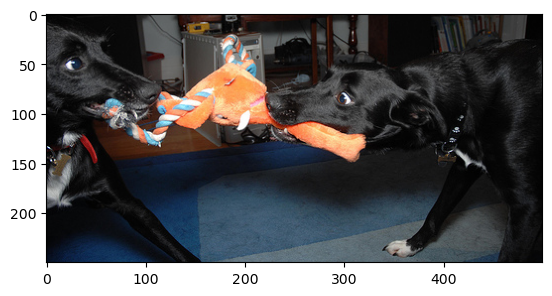

Запрос: a tan dog jumping through the field with some barren trees in the background, Изображение: 3553476195_fb3747d7c1.jpg, Оценка: 0.1350917947845243


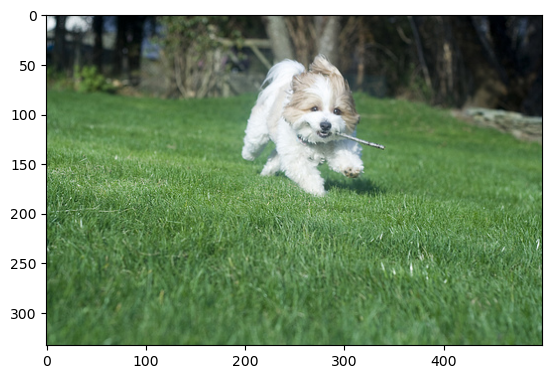

Запрос: A little white dog runs on freshly mown grass , holding a small stick ., Изображение: 3466891862_9afde75568.jpg, Оценка: 0.4259986876574312


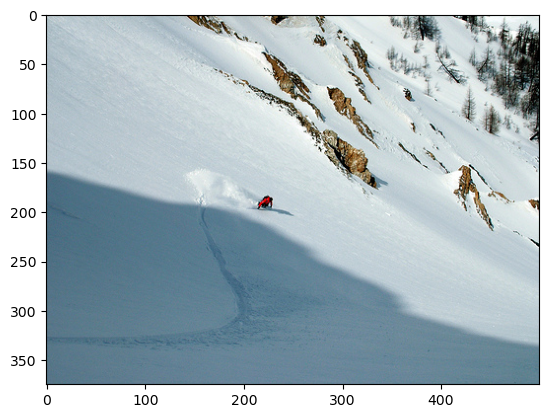

Запрос: One person snowboarding while others look on ., Изображение: 3386953179_84c2d7922f.jpg, Оценка: 0.1886237957825319


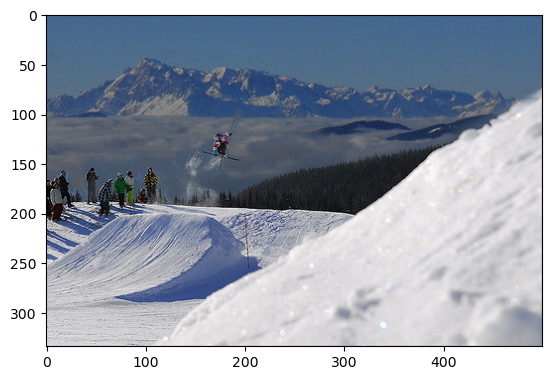

Запрос: A man demonstrating how high his black dog can jump ., Изображение: 3163198309_bbfe504f0a.jpg, Оценка: 0.25473357463351404


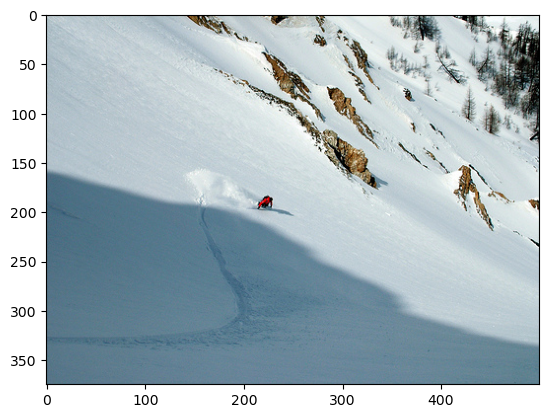

Запрос: A man in a blue shirt lifts up his tennis racket and smiles ., Изображение: 3386953179_84c2d7922f.jpg, Оценка: 0.21732094487408507


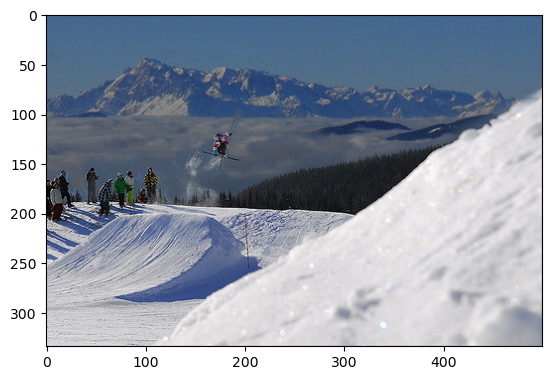

Запрос: A woman works by a sewing machine ., Изображение: 3163198309_bbfe504f0a.jpg, Оценка: 0.39978485912989165


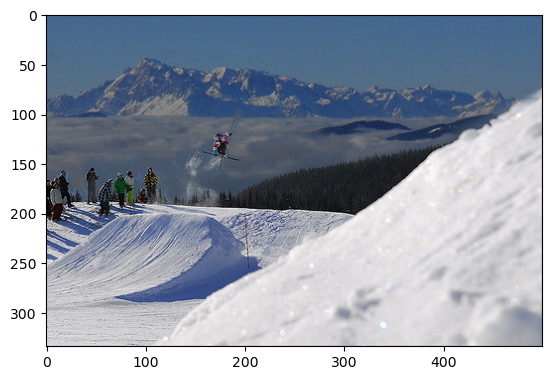

Запрос: a bmx rider gets some air ., Изображение: 3163198309_bbfe504f0a.jpg, Оценка: 0.3759288567995306


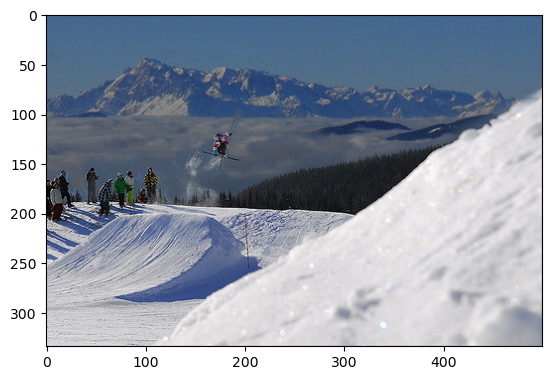

Запрос: A black dog holding a weight in its mouth stands next to a person ., Изображение: 3163198309_bbfe504f0a.jpg, Оценка: 0.20898003064467136


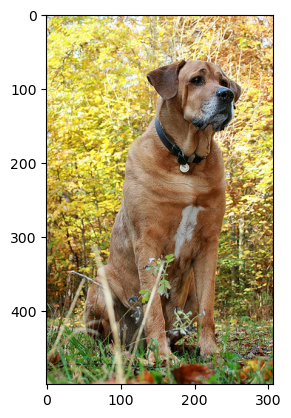

Запрос: Four people are cavorting on the rocks at a river 's edge, Изображение: 1745110280_0cbff5e273.jpg, Оценка: 0.1529139263823296


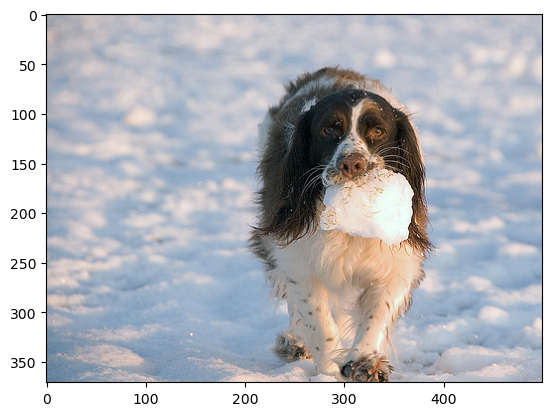

Запрос: a man wearing red socks playing running with some other men, Изображение: 3262849619_0bc4f88ef9.jpg, Оценка: 0.14314275520175637


In [75]:
queries = list(test['query_text'].sample(10))
for query in queries:
    image, score = search_similar_image(query, test, lgbm_model, model_bert, tokenizer, device)
    print(f'Запрос: {query}, Изображение: {image}, Оценка: {score}')

Результат предсказания модели очень плохой, буквально 1 или 2 текста хоть немного соответствуют картинке. Оценка, выдаваемая моделью так же очень низкая и для использования в ПРОД не подходит.

## Модель CLIP

Нейросеть CLIP от OpenAI — классификатор изображений, решающий практически любую задачу. В отличии от классических моделей, CLIP не нужно обучать. На выходе получаем отличный результат с минималным временем инференса.

Для начала загрузим все необходимые библиотеки и скачаем саму модель.

In [76]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
from tqdm.autonotebook import tqdm
import glob
from IPython.display import Image as IPImage

#Загрузка модели CLIP
model = SentenceTransformer('clip-ViT-B-32')

Загрузим наименования картинок в список и передлалим моделе для кодировки.

In [77]:
img_names = list(glob.glob(os.path.join(DATA_PATH, 'test_images/*.jpg')))
print("Images:", len(img_names))
img_emb = model.encode([Image.open(filepath) for filepath in img_names], 
                       batch_size=128, convert_to_tensor=True, show_progress_bar=True)

Images: 100


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Напишем фунцию для поиска картинки по описанию

In [78]:
def search(query, k=1):
    # Кодируем запрос
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    
    # Затем используем функцию util.semantic_search function, которая вычисляет
    # косинуидальное сходство, 
    # между эмбеддингом запроса и всех картинок.
    # Возвращает наиболее схожую картинку к запросу
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]
    
    print("Query:")
    display(query)
    for hit in hits:
        
        display(IPImage((img_names[hit['corpus_id']]), width=200))

Для наглядности выберем 10 случайных описаний текста и выведем картинку по запросу.

Query:


'Several dogs are running outside , with two vehicles in the background .'

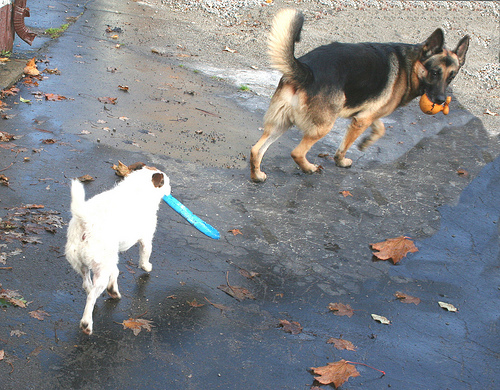

Query:


'Two dogs are standing next to each other , and the white dog has a stick in its mouth .'

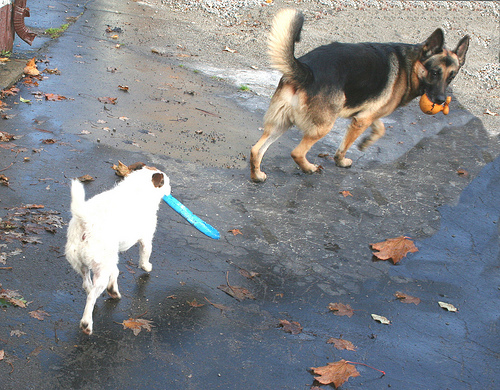

Query:


'Four people are playing basketball on a plank deck outdoors .'

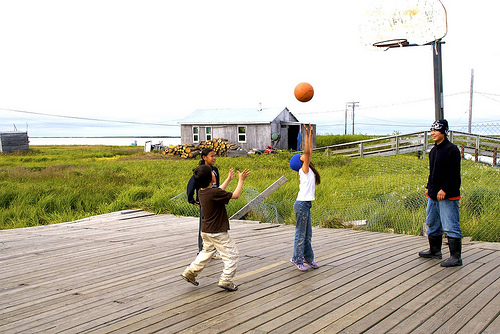

Query:


'Two people on a sled riding down a snowy hill .'

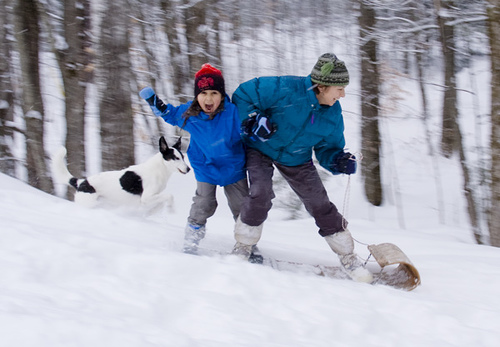

Query:


'Men playing with a red ring out in the field .'

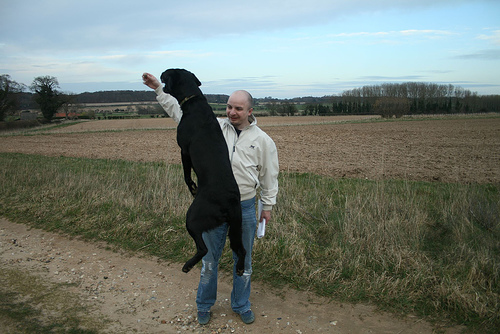

Query:


'An Arabic man in a white hat .'

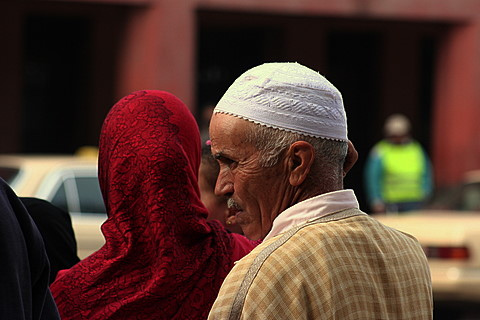

Query:


'A group of people perform together onstage .'

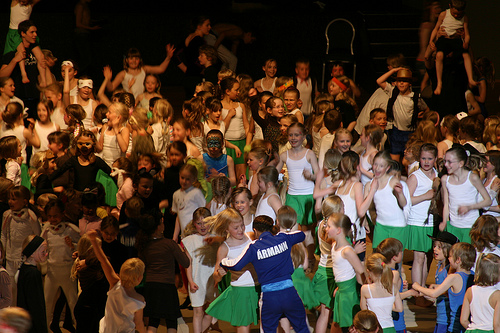

Query:


'A bird flying over the water .'

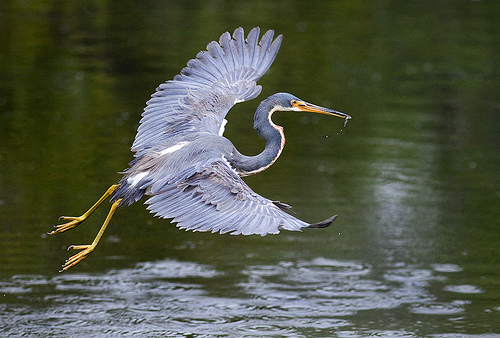

Query:


'Woman in colorful shirt works at sewing machine .'

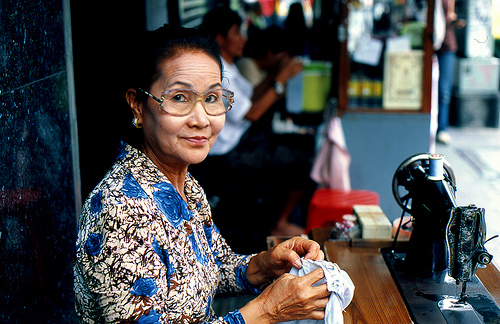

Query:


'A group of people walk through a shopping mall .'

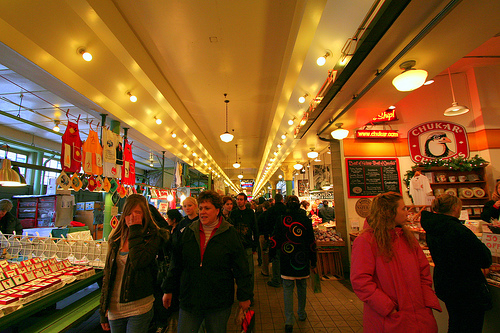

In [79]:
queries = list(test['query_text'].sample(10))

for query in queries:
    search(query)

## 8. Выводы

В ходе выполнения проекта загружены данные, совмещены оценки экспертов и краудсорсинга. Более 90% оценок указывают на полное отсутствие совпадения картинки и текста, только около 2% (1 260) комбинаций имеют полное соответствие. Так же нет возможности подтвердить корректность оценок, так как среди краудсорса оценки выполняли от 3 до 6 человек, а количество комбинаций с оценкой экспертов составляет около 10%.

Загружены тренировочные и тестовые запросы. Среди запросов, в соответствии с требованиями законодательства, удалены все текстовые запросы с запрещенными стоп-словами. Дополнительно удалены изображения, на которых соответствие текста и изображения более 50% и имеются стоп-слова. В результате этого, количество тренировочной выборки уменьшилось в 2 раза, а тестовой на 33%.

Для каждой выборки векторизованы тексты и изображения. Вектора объединены в единый вектор. На данном векторе проведено обучение моделей линейной регрессии, градиентного бустинга и нейронной сети. Проведена проверка на адекватность, которая показала, что модели градиентного бустинга и нейронная сеть предсказывают лучше dummy модели.

Для тестирования модели выбран градиентный бустинг, обучен на полной тренировочной выборке. Написана функция, которая возращает наиболее соответствующее тексту изображение. Качество предсказания на низком уровне и внедрение в реальный проект не рекомендуется. 9 из 10 изображений полностью не соответствуют тексту, на что указывает так же оценка самой модели. Вероятно стоит указать ограничение вывода изображения по оценке не ниже 0.66, в противном случае выводить ошибку "похожее изображение не найдено".

Наиболее вероятными причинами низкого качества предсказаний являются:
- сложность интерпретируемости сложенных векторов запросов;
- малая выборка для тренировки;
- недостаточно выполненный подбор модели и ее гиперпараметров;
- ограничения страны, в связи с чем часть разрешенных изображений не попадают в выборки;
- некорректно выбрана метрика;
- некорретно выбран класс моделей, в данном случае необходимо использовать рекомендательные модели.

Протестированная модель CLIP показывает идеальный результат, точно подбирая картинку под описание. 